In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(preprocessCore)
library(circlize)
`%ni%` <- Negate(`%in%`)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.4          ✔ stringr   1.5.1     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.2          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() m

In [2]:
get_CPM_values <- function(input, meta, cell_annot_alot){
  
  meta_data <- read.delim(meta) %>% 
        rename(cell_type = !!sym(cell_annot_alot)) 
    
    
  raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)
    
  merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

  ### Alt CPM Calc
  merged_meta_cpm_information_copied <- merged_meta_cpm_information
  catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()

  caught_values <- as_tibble(catch)
  #see <- ungroup(merged_meta_cpm_information_copied)
  merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, caught_values)  %>% 
    rename(grouped_CPM = value)
    
    
  quantile_normalized_values <- merged_meta_cpm_information_copied %>% 
        group_by(cell_type) %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    
    
  quantile_normalized <- as_tibble(quantile_normalized_values)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


  quantile_normalized_data <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized) %>% 
        group_by(geneID)
        #dplyr::mutate(Zscore = scale(quant_norm_cpm))



  return(quantile_normalized_data)
}



In [3]:
generate_matrix_for_heatmap <- function(cell_type_by_gene_by_quant_norm, markers) {
    
    
    mat <- cell_type_by_gene_by_quant_norm %>%
        #dplyr::filter(cell_type %in% c("mesophyll", "bundle_sheath")) %>% 
        dplyr::filter(geneID %in% markers$geneID) %>% 
        left_join(., markers, by = c("geneID")) %>% 
        dplyr::ungroup() %>%   
        dplyr::select(cell_type, name, quant_norm_cpm) %>% 
        pivot_wider(names_from = cell_type, values_from = quant_norm_cpm) %>% 
        dplyr::rowwise() %>% 
        dplyr::mutate(log2_val = log2(bundle_sheath/mesophyll)) %>% 
        dplyr::select(name, log2_val) 
}

In [4]:
output_location <- "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_2/heatmaps/"

In [5]:
pm_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/panicum_millet/acc_metrics_leaf/panicum_millet.gene_body_acc_leaf.counts.txt"
pm_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/pm_annot/Pm.leaf_annotation.V1.meta.txt"
pm_marker_genes <- read_delim("/home/jpm73279/genome_downloads/C4_markers/Pm.c4_markers.bed", delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))


Rows: 52 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
pm_cpm_values <- get_CPM_values(pm_gene_activity, pm_meta, "annotation_v1")

Rows: 54642541 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [7]:
pm_marker_genes

chrom,start,stop,geneID,name,type
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CM009691.2,16872592,16876727,RLN15714.1,Pm__AlaAT_1,bundle_sheath
CM009690.2,45874000,45877910,RLN40787.1,Pm__AlaAT_2,"mesophyll,bundle_sheath"
CM009690.2,45867729,45873222,RLN40227.1,Pm__AlaAT_3,"mesophyll,bundle_sheath"
CM009693.2,38692117,38696523,RLM86742.1,Pm__AlaAT_4,mesophyll
CM009692.2,10378557,10383189,RLN34837.1,Pm__AlaAT_5,bundle_sheath
CM009692.2,14116242,14120807,RLN33813.1,Pm__AlaAT_6,mesophyll
CM009700.2,42114192,42117475,RLN09924.1,Pm__AspAT_1,"mesophyll,bundle_sheath"
CM009701.2,40851809,40855107,RLM80284.1,Pm__AspAT_2,"mesophyll,bundle_sheath"
CM009696.2,41521468,41526151,RLN22614.1,Pm__AspAT_3,mesophyll


In [8]:
pm_marker_genes %>% 
    group_by(geneID) %>% 
    summarise(counts = n()) %>% 
    dplyr::filter(counts > 1)

geneID,counts
<chr>,<int>


In [9]:
pm_C4_matrix <- generate_matrix_for_heatmap(pm_cpm_values, pm_marker_genes)

In [10]:
remove_these <- c("Dit_3", "PPA3_2", "PPA3_1", "PPA2_1", "PPA1", "PPA2_2")
pm_C4_matrix.filtered <- pm_C4_matrix %>% 
    dplyr::filter(name %ni% remove_these)
pm_df <- data.frame(pm_C4_matrix.filtered, row.names = 1)

In [11]:
col_fun <- colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


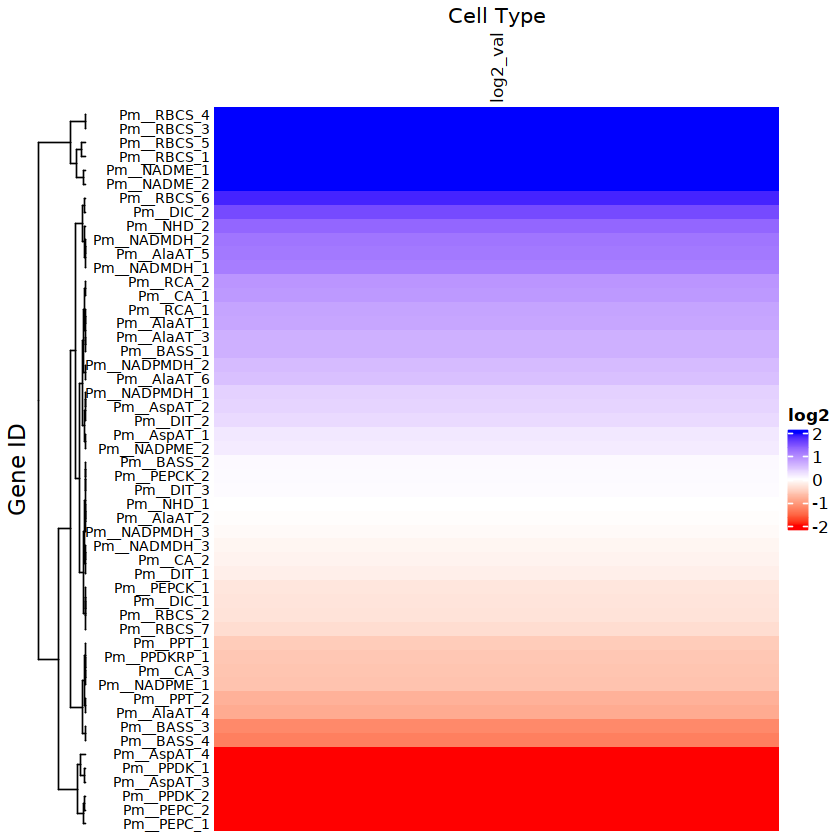

In [12]:
pm_heatmap <- Heatmap(
  pm_df,
  name = "log2",
  col = col_fun,
  #row_order = sb_gene_array, 
  row_names_side = "left",
  column_names_side = "top",
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Cell Type",
  row_title = "Gene ID"
#  column_order = column_order
)

pm_heatmap

In [13]:
pm_gene_array <- c(
"NAD-ME_1","NAD-ME_2",
"NADP-ME_1","NADP-ME_2","PEP-CK_1","PEP-CK_2","PEP-CK_3",
"RUBISCO_activase1_ortho_count_1","RUBISCO_activase1_ortho_count_2", "Dit_2",
"RBCA2_ortho_count_1__RBCA1_ortho_count_1","RBCA2_ortho_count_2__RBCA1_ortho_count_2",
"RBCA2_ortho_count_3__RBCA1_ortho_count_3","RBCA2_ortho_count_4__RBCA1_ortho_count_4",
"RBCA2_ortho_count_5__RBCA1_ortho_count_5","RBCA2_ortho_count_6__RBCA1_ortho_count_6",
"RBCA2_ortho_count_7__RBCA1_ortho_count_7",
"AspAT_1","AspAT_2","AspAT_3","AspAT_4","AlaAT8_ortho_count_1","DIC1_",
"BASS_ortho_count_1","BASS_ortho_count_2","AlaAT2_ortho_count_1","AlaAT2_ortho_count_2","CA_1","CA_2",
"PPT_1","PPT_2", "PPT_3","PPT_4","Dit_1",
"AlaAT1_ortho_count_1","AlaAT1_ortho_count_2","PPDK_1",
"PPDK_2","CA6_ortho_count_2","CA6_ortho_count_3",
"NADP-MDH_1","NADP-MDH_2","NADP-MDH_3",
"PPDK-RP","PEPC_1","PEPC_2")


In [14]:
remove_these <- c("Dit_3", "PPA3_2", "PPA3_1", "PPA2_1", "PPA1", "PPA2_2")

In [15]:
pm_C4_matrix.filtered %>% 
    dplyr::filter(name %ni% pm_gene_array)

pm_C4_matrix.filtered.df <- data.frame(pm_C4_matrix.filtered, row.names = 1)

name,log2_val
<chr>,<dbl>
Pm__PEPC_2,-3.650235758
Pm__RCA_1,0.786789940
Pm__PPT_2,-0.806052304
Pm__NADPMDH_3,-0.052075954
Pm__RCA_2,0.911708127
Pm__AspAT_2,0.361936539
Pm__NHD_1,0.003206481
Pm__PPDKRP_1,-0.586309404
Pm__AlaAT_4,-0.870325518


In [16]:
pm_heatmap <- Heatmap(
  pm_C4_matrix.filtered.df,
  name = "log2",
  col = col_fun,
  row_order = pm_gene_array, 
  row_names_side = "left",
  column_names_side = "top",
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Cell Type",
  row_title = "Gene ID"
#  column_order = column_order
)

pm_heatmap

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


ERROR: Error: `row_order` should not contain NA values.


In [17]:
# Function definition
filter_tribble_by_name <- function(data, names) {
  updated <- data %>%
    filter(name %in% names)
    
    updated <- data.frame(updated, row.names = 1)
    return(updated)
}


# Generate Core C4 Gene Heatmaps

In [18]:
col_fun <- colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))


generate_split_heatmap <- function(log2matrix, df_marker_type) {
    
     updated <- log2matrix %>%
        filter(name %in% df_marker_type$name) %>% 
        left_join(.,df_marker_type, by = c("name")) %>% 
        dplyr::ungroup() %>% 
        dplyr::group_by(cell_type) %>% 
        dplyr::arrange(desc(log2_val), .by_group = TRUE) %>% 
        mutate(name = str_replace_all(name, "_ortho_count_", "_"))


    return(updated)
    
}

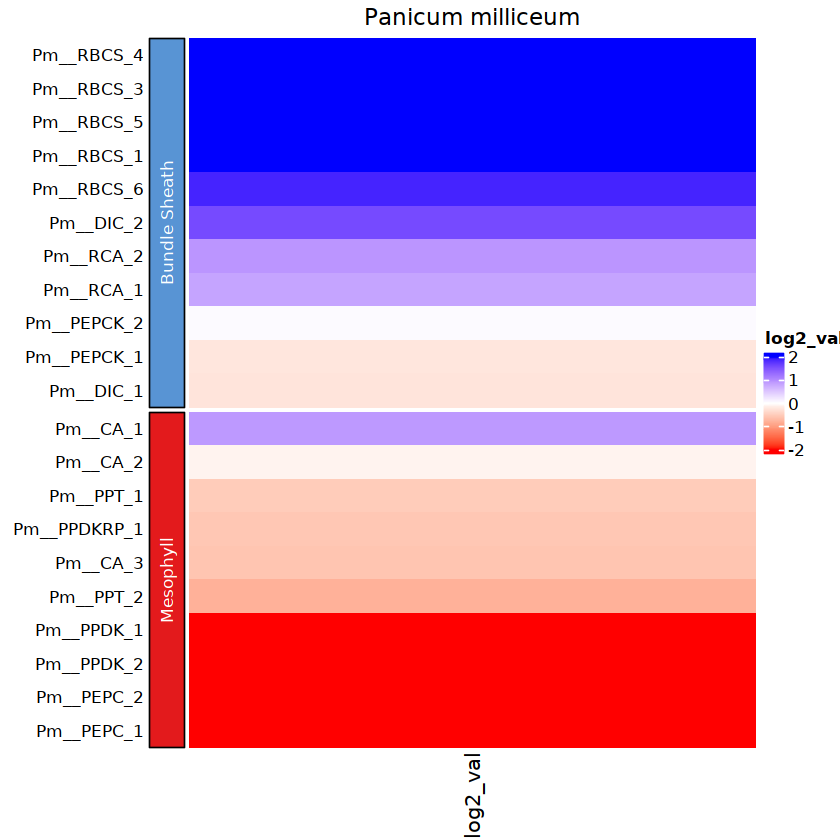

In [19]:
pm_genes <- data.frame(
  name = c("Pm__CA_1", "Pm__CA_2", "Pm__CA_3", "Pm__DIC_1", "Pm__DIC_2",
           "Pm__PEPC_1", "Pm__PEPC_2", "Pm__PEPCK_1", "Pm__PEPCK_2", "Pm__PPDK_1",
           "Pm__PPDK_2", "Pm__PPT_1", "Pm__PPT_2", "Pm__RBCS_1", "Pm__RBCS_3",
           "Pm__RBCS_4", "Pm__RBCS_5", "Pm__RBCS_6", "Pm__RCA_1", "Pm__RCA_2",
           "Pm__PPDKRP_1"),
  cell_type = c("Mesophyll", "Mesophyll", "Mesophyll", "Bundle Sheath", "Bundle Sheath",
                "Mesophyll", "Mesophyll", "Bundle Sheath", "Bundle Sheath", "Mesophyll",
                "Mesophyll", "Mesophyll", "Mesophyll", "Bundle Sheath", "Bundle Sheath",
                "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", 
                "Bundle Sheath", "Mesophyll")
)
# Convert factors if necessary
pm_genes$name <- as.factor(pm_genes$name)
pm_genes$cell_type <- as.factor(pm_genes$cell_type)



pm_data_merged <- generate_split_heatmap(pm_C4_matrix ,pm_genes)

pm_data_generate_matrix <- as.matrix(pm_data_merged[,"log2_val"])
rownames(pm_data_generate_matrix) <- pm_data_merged$name

# create heatmap
pm_heatmap <- Heatmap(pm_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = pm_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                    row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(pm_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Panicum milliceum",
                   row_title_gp = gpar(fontsize = 14))

pm_heatmap

# Generate heatmap for Subtypes

In [21]:
pm_C4_matrix

name,log2_val
<chr>,<dbl>
Pm__PEPC_2,-3.650235758
Pm__RCA_1,0.786789940
Pm__PPT_2,-0.806052304
Pm__NADPMDH_3,-0.052075954
Pm__RCA_2,0.911708127
Pm__AspAT_2,0.361936539
Pm__NHD_1,0.003206481
Pm__PPDKRP_1,-0.586309404
Pm__AlaAT_4,-0.870325518


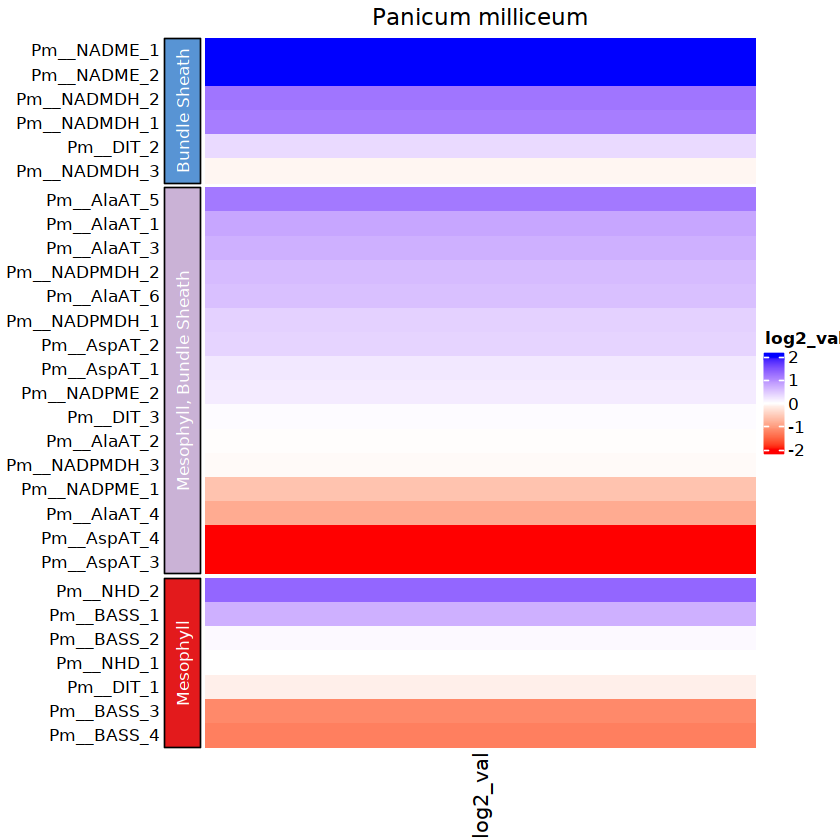

In [22]:
#pm_genes_subtype_c4 <- data.frame(
#  name = c("NADP-ME_1", "NADP-ME_2", "NAD-ME_1", "NAD-ME_2", "NADP-MDH_1", "NADP-MDH_2", "NADP-MDH_3"),
#  cell_type = c("Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Mesophyll", "Mesophyll", "Mesophyll")
#)

pm_genes_subtype_c4 <- data.frame(
  cell_type = c("Mesophyll, Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath",
                "Bundle Sheath", "Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll",
                "Mesophyll", "Mesophyll", "Bundle Sheath", "Mesophyll, Bundle Sheath",
                "Mesophyll", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
               "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", "Mesophyll","Mesophyll"),
  name = c("Pm__AlaAT_6", "Pm__NADMDH_1", "Pm__NADMDH_3", "Pm__NADMDH_2",
           "Pm__NADME_1", "Pm__NADME_2", "Pm__NADPMDH_1", "Pm__NADPME_1",
           "Pm__NADPME_2", "Pm__AlaAT_1", "Pm__AlaAT_2", "Pm__AlaAT_3",
           "Pm__AlaAT_4", "Pm__AlaAT_5", "Pm__AspAT_1", "Pm__AspAT_2",
           "Pm__BASS_1", "Pm__BASS_2", "Pm__DIT_1", "Pm__DIT_2",
           "Pm__DIT_3", "Pm__NHD_1", "Pm__AspAT_3", "Pm__AspAT_4",
          "Pm__NADPMDH_2", "Pm__NADPMDH_3","Pm__BASS_3", "Pm__BASS_4", "Pm__NHD_2")
)


pm_genes_subtype_c4$cell_type <- as.factor(pm_genes_subtype_c4$cell_type)
pm_genes_subtype_c4$cell_type <- factor(pm_genes_subtype_c4$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
pm_genes_subtype_c4 <-  pm_genes_subtype_c4 %>% 
    arrange(cell_type)



pm_data_merged_subtypes <- generate_split_heatmap(pm_C4_matrix, pm_genes_subtype_c4)

pm_data_generate_matrix_subtype <- as.matrix(pm_data_merged_subtypes[,"log2_val"])
rownames(pm_data_generate_matrix_subtype) <- pm_data_merged_subtypes$name


# create heatmap
pm_heatmap_subtypes <- Heatmap(pm_data_generate_matrix_subtype, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = pm_data_merged_subtypes$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                    row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4","#CAB2D6", "#E31A1C")),
                        labels = unique(pm_data_merged_subtypes$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Panicum milliceum",
                   row_title_gp = gpar(fontsize = 14))



pm_heatmap_subtypes

In [23]:
pm_data_generate_matrix_subtype

,log2_val
Pm__NADME_1,3.449865960
Pm__NADME_2,2.975327449
Pm__NADMDH_2,1.197947586
Pm__NADMDH_1,1.127696833
Pm__DIT_2,0.310646686
Pm__NADMDH_3,-0.098642773
Pm__AlaAT_5,1.163363706
Pm__AlaAT_1,0.764267751
Pm__AlaAT_3,0.677936879
Pm__NADPMDH_2,0.585155344


In [24]:
output_function <- function(output_place, heatmap, name) {
    file_name <- paste0(output_place, name)
    pdf(file = file_name, height = 6, width = 4)
    draw(heatmap)
    dev.off()
}

In [26]:
output_function(output_location, pm_heatmap, "pm_core_c4_genes.pdf")
output_function(output_location, pm_heatmap_subtypes, "pm_variable_c4_genes.pdf")

png 
  2

png 
  2